# STATS 201 – Course Project

## Predicting Population Decline Using Migration and Demographic Data


## Imports and Environment Setup

In this section, we import the required Python libraries and configure basic display settings.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings for better readability
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## Loading the Dataset

The dataset contains population and migration data for 186 countries over multiple decades.  
We load the CSV file and inspect its basic structure.

In [20]:
# Load dataset from local directory
df_raw = pd.read_csv("world_pop_mig_186_countries.csv")

# Inspect dataset shape and first few rows
df_raw.shape

(11904, 5)

## Data Cleaning and Structure

We standardize column names, identify key variables, and ensure the data are sorted correctly for time-series analysis.

In [21]:
# Standardize column names (This will help with the usage of the variable later, because we won't have variables with space " " for confusion)
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identify country and year columns
country_col = next((c for c in df.columns if "country" in c), None)
year_col = "year"

# Convert year to numeric and sort data
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")

# Remove the data that gets NaN after the conversion
df = df.dropna(subset=[year_col])
df[year_col] = df[year_col].astype(int)

df = df.sort_values([country_col, year_col]).reset_index(drop=True)

print(f"Cleaned dataset:")
print(f"Shape: {df.shape}")
print(f"Countries: {df[country_col].nunique()}")
print(f"Year range: {df[year_col].min()} to {df[year_col].max()}")
print(f"\nColumns: {df.columns.tolist()}")

Cleaned dataset:
Shape: (11904, 5)
Countries: 186
Year range: 1960 to 2023

Columns: ['country', 'year', 'population', 'netmigration', 'population_in_millions']


## Key Variables

We identify numeric variables related to population and migration that will later be used as predictors in the machine learning models.

In [22]:
# Identify columns that have numerical data
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


# Identify population and migration-related variables
pop_candidates = [c for c in numeric_cols if "pop" in c]
mig_candidates = [c for c in numeric_cols if "migration" in c]

print(f"Population-related columns: {pop_candidates}")
print(f"Migration-related columns: {mig_candidates}")

Population-related columns: ['population', 'population_in_millions']
Migration-related columns: ['netmigration']


## Derived Variables

We create simple derived variables such as population growth rate and lagged migration values to support exploratory analysis.

In [23]:
POP_COL = pop_candidates[0]
MIG_COL = mig_candidates[0]

# Lagged population
df["pop_lag1"] = df.groupby(country_col)[POP_COL].shift(1)

# Population growth rate
df["pop_growth_rate"] = (df[POP_COL] - df["pop_lag1"]) / df["pop_lag1"]

# Lagged migration
df["mig_lag1"] = df.groupby(country_col)[MIG_COL].shift(1)

# Log population for scale normalization
df["log_pop"] = np.log(df[POP_COL].replace({0: np.nan}))

print("Derived variables created: ")
print(df[[country_col, year_col, POP_COL, MIG_COL, "pop_growth_rate"]].head())

Derived variables created: 
       country  year  population  netmigration  pop_growth_rate
0  Afghanistan  1960   8622466.0        2606.0              NaN
1  Afghanistan  1961   8790140.0        6109.0         0.019446
2  Afghanistan  1962   8969047.0        7016.0         0.020353
3  Afghanistan  1963   9157465.0        6681.0         0.021008
4  Afghanistan  1964   9355514.0        7079.0         0.021627


## Initial Exploratory Analysis

This section explores global trends in population growth and migration over time, as well as their relationship.

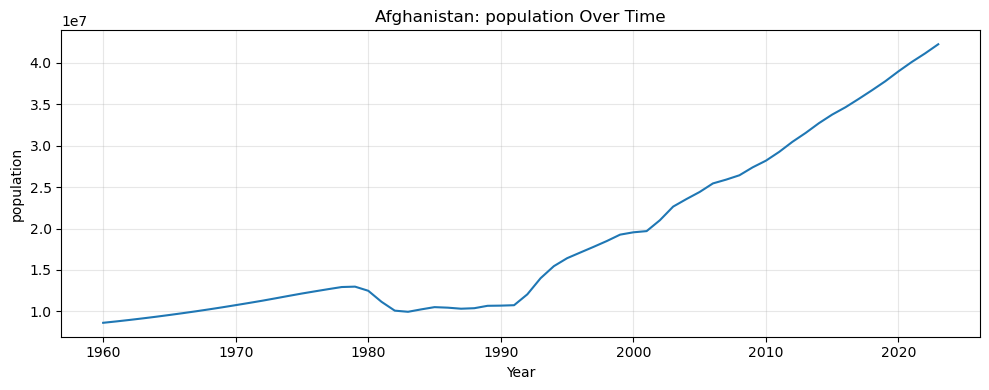

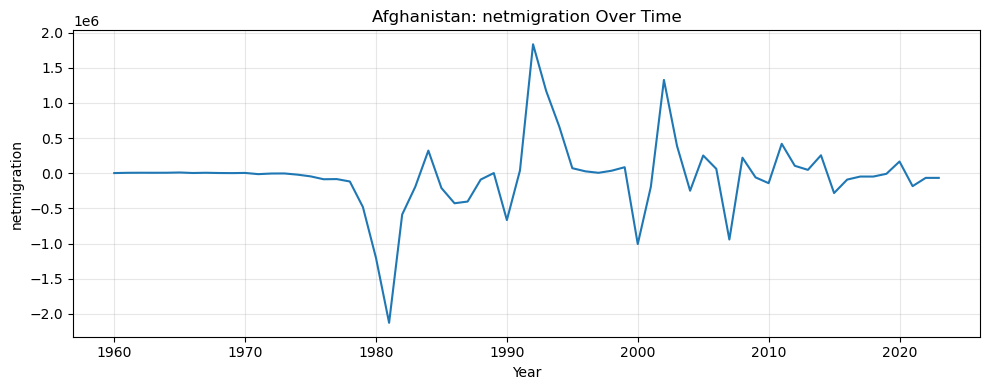

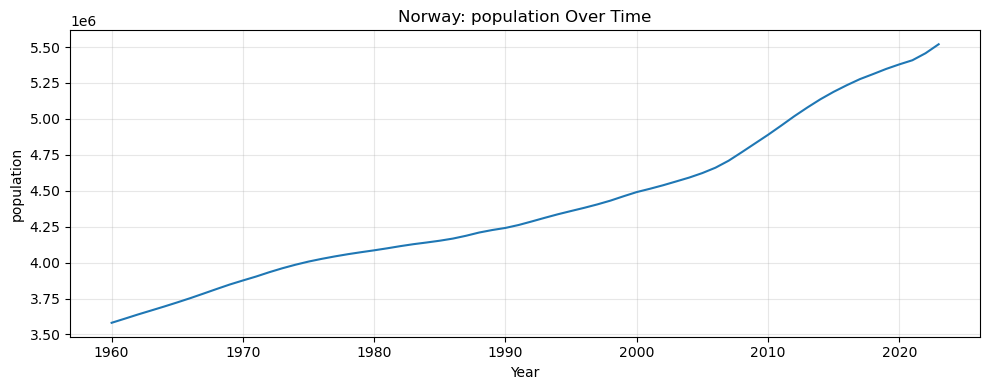

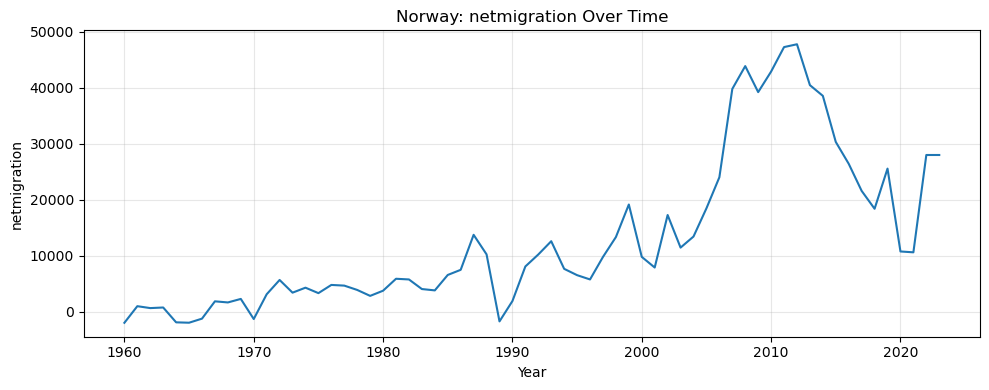

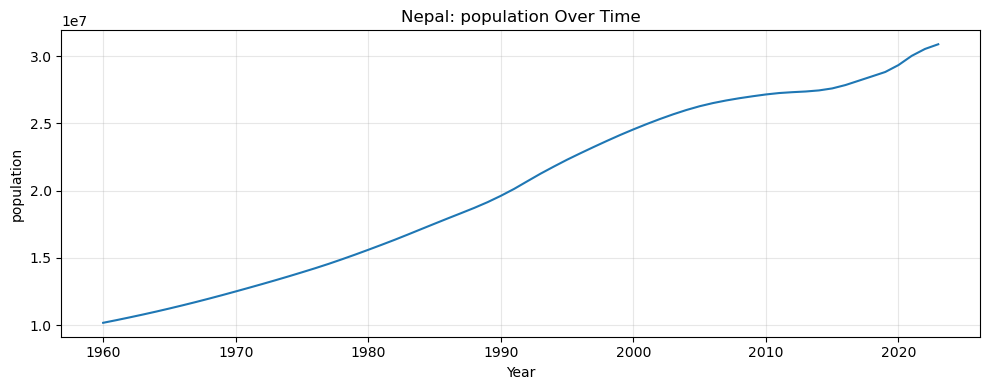

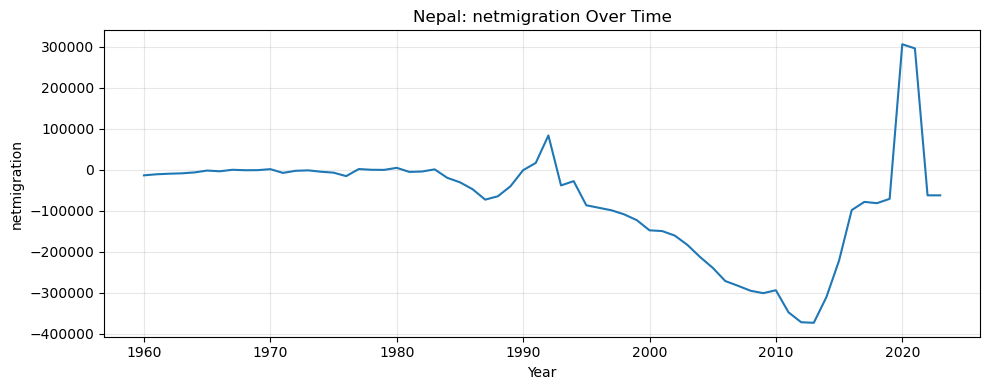

In [24]:
# Select a small subset of countries for visualization
# We use countries with the highest number of observations to ensure complete time series
top_countries = df[country_col].value_counts().head(3).index.tolist()

# Plot population and migration trends over time for selected countries
for c in top_countries:
    
    # Subset data for a single country and sort by year
    d = df[df[country_col] == c].sort_values(year_col)
    
    # Plot population over time
    plt.figure(figsize=(10, 4))
    plt.plot(d[year_col], d[POP_COL])
    plt.title(f"{c}: {POP_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(POP_COL)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot migration over time
    plt.figure(figsize=(10, 4))
    plt.plot(d[year_col], d[MIG_COL])
    plt.title(f"{c}: {MIG_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(MIG_COL)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Standardize Column Names for Modeling

In [25]:
# Standardize column names to match what we'll use for modeling
df = df.rename(columns={
    country_col: 'Country Name',
    year_col: 'Year', 
    POP_COL: 'Population',
    MIG_COL: 'Net Migration',
    'pop_growth_rate': 'Population Growth'
})

# Keep only essential columns and clean up
columns_to_keep = ['Country Name', 'Year', 'Population', 'Net Migration', 'Population Growth']
df = df[columns_to_keep].copy()

print("=" * 70)
print("DATA PREPARATION FOR MODELING")
print("=" * 70)
print(f"Dataset shape: {df.shape}")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
print(f"Countries: {df['Country Name'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

DATA PREPARATION FOR MODELING
Dataset shape: (11904, 5)
Years: 1960 to 2023
Countries: 186

Columns: ['Country Name', 'Year', 'Population', 'Net Migration', 'Population Growth']

First few rows:
  Country Name  Year  Population  Net Migration  Population Growth
0  Afghanistan  1960   8622466.0         2606.0                NaN
1  Afghanistan  1961   8790140.0         6109.0           0.019446
2  Afghanistan  1962   8969047.0         7016.0           0.020353
3  Afghanistan  1963   9157465.0         6681.0           0.021008
4  Afghanistan  1964   9355514.0         7079.0           0.021627


## Create Target Variable: Population Decline

We define our prediction task: **Can we predict if a country will experience population decline in the next N years?**

- **Prediction Window:** N = 5 years
- **Target Definition:** Binary (1 = decline occurs, 0 = no decline)
- **Decline Definition:** Population at any point in next 5 years drops below current year

In [26]:
# Set prediction window
PREDICTION_WINDOW = 5  # Predict decline in next 5 years

def create_decline_target(df, country_col='Country Name', year_col='Year', 
                         pop_col='Population', window=5):
    
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Sort by country and year to ensure proper time ordering
    df = df.sort_values([country_col, year_col]).reset_index(drop=True)
    
    # Initialize target variable
    df['future_decline'] = 0
    
    print(f"Creating target variable with {window}-year prediction window...")
    
    # For each country, check if population declines in the next N years
    for country in df[country_col].unique():
        # Get data for this country only
        country_mask = df[country_col] == country
        country_indices = df[country_mask].index
        
        # For each year in this country's data
        for idx in country_indices:
            current_year = df.loc[idx, year_col]
            current_pop = df.loc[idx, pop_col]
            
            # Skip if current population is missing
            if pd.isna(current_pop):
                continue
            
            # Look ahead N years (strict inequality: future_year > current_year)
            future_mask = (
                (df[country_col] == country) & 
                (df[year_col] > current_year) & 
                (df[year_col] <= current_year + window)
            )
            
            future_data = df[future_mask]
            
            # Check if any future population is lower than current
            if len(future_data) > 0:
                min_future_pop = future_data[pop_col].min()
                
                # If future population drops below current, mark as decline
                if not pd.isna(min_future_pop) and min_future_pop < current_pop:
                    df.loc[idx, 'future_decline'] = 1
    
    return df

# Apply target variable creation
df = create_decline_target(
    df, 
    country_col='Country Name', 
    year_col='Year', 
    pop_col='Population',
    window=PREDICTION_WINDOW
)

# Check results
print("\n" + "=" * 70)
print("TARGET VARIABLE CREATED")
print("=" * 70)
print(f"Total observations: {len(df)}")
print(f"Decline cases: {df['future_decline'].sum()} ({df['future_decline'].mean()*100:.2f}%)")
print(f"No decline cases: {(df['future_decline']==0).sum()} ({(df['future_decline']==0).mean()*100:.2f}%)")

# Show some examples
print(f"\nSample of data with target variable:")
print(df[['Country Name', 'Year', 'Population', 'future_decline']].head(20))

Creating target variable with 5-year prediction window...

TARGET VARIABLE CREATED
Total observations: 11904
Decline cases: 1388 (11.66%)
No decline cases: 10516 (88.34%)

Sample of data with target variable:
   Country Name  Year  Population  future_decline
0   Afghanistan  1960   8622466.0               0
1   Afghanistan  1961   8790140.0               0
2   Afghanistan  1962   8969047.0               0
3   Afghanistan  1963   9157465.0               0
4   Afghanistan  1964   9355514.0               0
5   Afghanistan  1965   9565147.0               0
6   Afghanistan  1966   9783147.0               0
7   Afghanistan  1967  10010030.0               0
8   Afghanistan  1968  10247780.0               0
9   Afghanistan  1969  10494489.0               0
10  Afghanistan  1970  10752971.0               0
11  Afghanistan  1971  11015857.0               0
12  Afghanistan  1972  11286753.0               0
13  Afghanistan  1973  11575305.0               0
14  Afghanistan  1974  11869879.0        

## Remove Incomplete Observations

In [27]:
# Calculate the last year we can make predictions for
MAX_YEAR = df['Year'].max()
LAST_PREDICTION_YEAR = MAX_YEAR - PREDICTION_WINDOW

print("=" * 70)
print("REMOVING INCOMPLETE OBSERVATIONS")
print("=" * 70)
print(f"Dataset spans: {df['Year'].min()} to {df['Year'].max()}")
print(f"Prediction window: {PREDICTION_WINDOW} years")
print(f"Last year we can predict for: {LAST_PREDICTION_YEAR}")
print(f"(We need data through {LAST_PREDICTION_YEAR + PREDICTION_WINDOW} to verify predictions)")

# Keep only observations where we can observe the full future window
df_modeling = df[df['Year'] <= LAST_PREDICTION_YEAR].copy()

print(f"\nObservations before: {len(df)}")
print(f"Observations after: {len(df_modeling)}")
print(f"Observations dropped: {len(df) - len(df_modeling)}")
print(f"\nNew year range: {df_modeling['Year'].min()} to {df_modeling['Year'].max()}")

REMOVING INCOMPLETE OBSERVATIONS
Dataset spans: 1960 to 2023
Prediction window: 5 years
Last year we can predict for: 2018
(We need data through 2023 to verify predictions)

Observations before: 11904
Observations after: 10974
Observations dropped: 930

New year range: 1960 to 2018


## Train-Test Split

In [28]:
# Define split year
TRAIN_END_YEAR = 2010
TEST_START_YEAR = 2011

# Create train and test sets based on time
train_data = df_modeling[df_modeling['Year'] <= TRAIN_END_YEAR].copy()
test_data = df_modeling[df_modeling['Year'] >= TEST_START_YEAR].copy()

print("=" * 70)
print("TEMPORAL TRAIN-TEST SPLIT")
print("=" * 70)
print(f"\n📊 TRAINING SET")
print(f"   Period: {train_data['Year'].min()} to {train_data['Year'].max()}")
print(f"   Observations: {len(train_data):,}")
print(f"   Countries: {train_data['Country Name'].nunique()}")
print(f"   Decline rate: {train_data['future_decline'].mean()*100:.2f}%")
print(f"   Decline cases: {train_data['future_decline'].sum():,}")

print(f"\n📊 TEST SET")
print(f"   Period: {test_data['Year'].min()} to {test_data['Year'].max()}")
print(f"   Observations: {len(test_data):,}")
print(f"   Countries: {test_data['Country Name'].nunique()}")
print(f"   Decline rate: {test_data['future_decline'].mean()*100:.2f}%")
print(f"   Decline cases: {test_data['future_decline'].sum():,}")

# Verify no overlap
assert train_data['Year'].max() < test_data['Year'].min(), "ERROR: Train and test overlap!"
print("\n✓ Verified: No temporal overlap between train and test sets")

TEMPORAL TRAIN-TEST SPLIT

📊 TRAINING SET
   Period: 1960 to 2010
   Observations: 9,486
   Countries: 186
   Decline rate: 10.09%
   Decline cases: 957

📊 TEST SET
   Period: 2011 to 2018
   Observations: 1,488
   Countries: 186
   Decline rate: 18.88%
   Decline cases: 281

✓ Verified: No temporal overlap between train and test sets


## Time-Lagged Feature Engineering

In [29]:
def create_lag_features(df, country_col='Country Name', lag_years=[1, 3, 5]):
    
    df = df.sort_values([country_col, 'Year']).copy()
    
    # Columns to create lags for
    cols_to_lag = ['Population', 'Net Migration', 'Population Growth']
    
    print(f"Creating lag features for lags: {lag_years}")
    
    for lag in lag_years:
        for col in cols_to_lag:
            if col in df.columns:
                # shift(lag) moves values DOWN by 'lag' rows within each country
                df[f'{col}_lag{lag}'] = df.groupby(country_col)[col].shift(lag)
                
    return df

# Apply lag feature creation
print("=" * 70)
print("FEATURE ENGINEERING: LAG FEATURES")
print("=" * 70)
train_data = create_lag_features(train_data)
test_data = create_lag_features(test_data)

print("✓ Lag features created!")
print(f"\nNew lag feature columns:")
lag_cols = [col for col in train_data.columns if 'lag' in col]
for col in lag_cols:
    print(f"  - {col}")

FEATURE ENGINEERING: LAG FEATURES
Creating lag features for lags: [1, 3, 5]
Creating lag features for lags: [1, 3, 5]
✓ Lag features created!

New lag feature columns:
  - Population_lag1
  - Net Migration_lag1
  - Population Growth_lag1
  - Population_lag3
  - Net Migration_lag3
  - Population Growth_lag3
  - Population_lag5
  - Net Migration_lag5
  - Population Growth_lag5


## Chage Feature Function

In [30]:
def create_change_features(df, country_col='Country Name'):
    
    df = df.sort_values([country_col, 'Year']).copy()
    
    # Year-over-year changes (absolute and percentage)
    for col in ['Population', 'Net Migration']:
        if col in df.columns:
            # Absolute change from previous year
            df[f'{col}_change'] = df.groupby(country_col)[col].diff()
            
            # Percentage change from previous year
            df[f'{col}_pct_change'] = df.groupby(country_col)[col].pct_change()
    
    # Rolling statistics (5-year moving average)
    for col in ['Population', 'Population Growth']:
        if col in df.columns:
            df[f'{col}_ma5'] = (
                df.groupby(country_col)[col]
                .rolling(window=5, min_periods=3)
                .mean()
                .reset_index(level=0, drop=True)
            )
    
    return df

print("=" * 70)
print("FEATURE ENGINEERING: CHANGE FEATURES")
print("=" * 70)
train_data = create_change_features(train_data)
test_data = create_change_features(test_data)

print("✓ Change features created!")
print(f"\nNew change feature columns:")
change_cols = [col for col in train_data.columns if any(x in col for x in ['change', 'ma5'])]
for col in change_cols:
    print(f"  - {col}")

FEATURE ENGINEERING: CHANGE FEATURES
✓ Change features created!

New change feature columns:
  - Population_change
  - Population_pct_change
  - Net Migration_change
  - Net Migration_pct_change
  - Population_ma5
  - Population Growth_ma5


## Domain-Specific Features

In [31]:
def create_domain_features(df, country_col='Country Name'):
    
    df = df.copy()
    
    # Migration as percentage of population (migration intensity)
    if 'Net Migration' in df.columns and 'Population' in df.columns:
        df['migration_intensity'] = df['Net Migration'] / df['Population']
    
    # Decade indicators (for capturing era-specific effects)
    df['decade'] = (df['Year'] // 10) * 10
    
    # Years since data start (time trend)
    df['years_since_start'] = df['Year'] - df['Year'].min()
    
    return df

print("=" * 70)
print("FEATURE ENGINEERING: DOMAIN FEATURES")
print("=" * 70)
train_data = create_domain_features(train_data)
test_data = create_domain_features(test_data)

print("✓ Domain features created!")
print(f"\nTotal columns now: {len(train_data.columns)}")
print(f"\nAll features created:")
feature_cols = [col for col in train_data.columns if col not in ['Country Name', 'Year', 'future_decline']]
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

FEATURE ENGINEERING: DOMAIN FEATURES
✓ Domain features created!

Total columns now: 24

All features created:
   1. Population
   2. Net Migration
   3. Population Growth
   4. Population_lag1
   5. Net Migration_lag1
   6. Population Growth_lag1
   7. Population_lag3
   8. Net Migration_lag3
   9. Population Growth_lag3
  10. Population_lag5
  11. Net Migration_lag5
  12. Population Growth_lag5
  13. Population_change
  14. Population_pct_change
  15. Net Migration_change
  16. Net Migration_pct_change
  17. Population_ma5
  18. Population Growth_ma5
  19. migration_intensity
  20. decade
  21. years_since_start


## Missing Data Analysis

In [32]:
from sklearn.impute import SimpleImputer

# Analyze missing data in training set
print("=" * 70)
print("MISSING DATA ANALYSIS (Training Set)")
print("=" * 70)

missing_train = train_data.isnull().sum()
missing_train_pct = (train_data.isnull().sum() / len(train_data)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_train,
    'Missing_Percent': missing_train_pct
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

if len(missing_summary) > 0:
    print("\nColumns with missing values:")
    print(missing_summary)
else:
    print("\nNo missing values found!")

MISSING DATA ANALYSIS (Training Set)

Columns with missing values:
                          Missing_Count  Missing_Percent
Population Growth_lag5             1116        11.764706
Population_lag5                     930         9.803922
Net Migration_lag5                  930         9.803922
Population Growth_lag3              744         7.843137
Population_lag3                     558         5.882353
Net Migration_lag3                  558         5.882353
Population Growth_ma5               558         5.882353
Population Growth_lag1              372         3.921569
Population_ma5                      372         3.921569
Net Migration_pct_change            272         2.867384
Population Growth                   186         1.960784
Population_lag1                     186         1.960784
Net Migration_lag1                  186         1.960784
Population_change                   186         1.960784
Population_pct_change               186         1.960784
Net Migration_change 

## Impute Missing Data

In [34]:
# Identify numeric columns for imputation
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variable and identifier columns from imputation
cols_to_exclude = ['future_decline', 'Year', 'decade', 'years_since_start']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print(f"Numeric columns to impute: {len(numeric_cols)}")

# Check for problematic columns (all NaN or all infinite)
problematic_cols = []
for col in numeric_cols:
    # Check if column is all NaN
    if train_data[col].isna().all():
        problematic_cols.append(col)
        print(f"⚠ Warning: Column '{col}' is entirely NaN - will be removed")
        continue
    
    # Check for infinite values
    if np.isinf(train_data[col]).any():
        print(f"⚠ Warning: Column '{col}' contains infinite values - replacing with NaN")
        train_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        test_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove problematic columns
numeric_cols = [col for col in numeric_cols if col not in problematic_cols]

print(f"\nColumns after cleaning: {len(numeric_cols)}")

# Check if we have valid columns to impute
if len(numeric_cols) == 0:
    print("⚠ No valid numeric columns to impute!")
else:
    # Fit imputer on training data ONLY
    imputer = SimpleImputer(strategy='median')
    
    # Fit on training data
    imputer.fit(train_data[numeric_cols])
    
    # Transform both train and test using the fitted imputer
    train_data[numeric_cols] = imputer.transform(train_data[numeric_cols])
    test_data[numeric_cols] = imputer.transform(test_data[numeric_cols])
    
    print("\n✓ Missing data imputed using median strategy")
    print(f"  Remaining missing values in train: {train_data[numeric_cols].isnull().sum().sum()}")
    print(f"  Remaining missing values in test: {test_data[numeric_cols].isnull().sum().sum()}")

Numeric columns to impute: 19
⚠ Warning: Column 'Net Migration_pct_change' contains infinite values - replacing with NaN

Columns after cleaning: 19

✓ Missing data imputed using median strategy
  Remaining missing values in train: 0
  Remaining missing values in test: 0


/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_87374/3155138984.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_87374/3155138984.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

## Class Balance Visualization

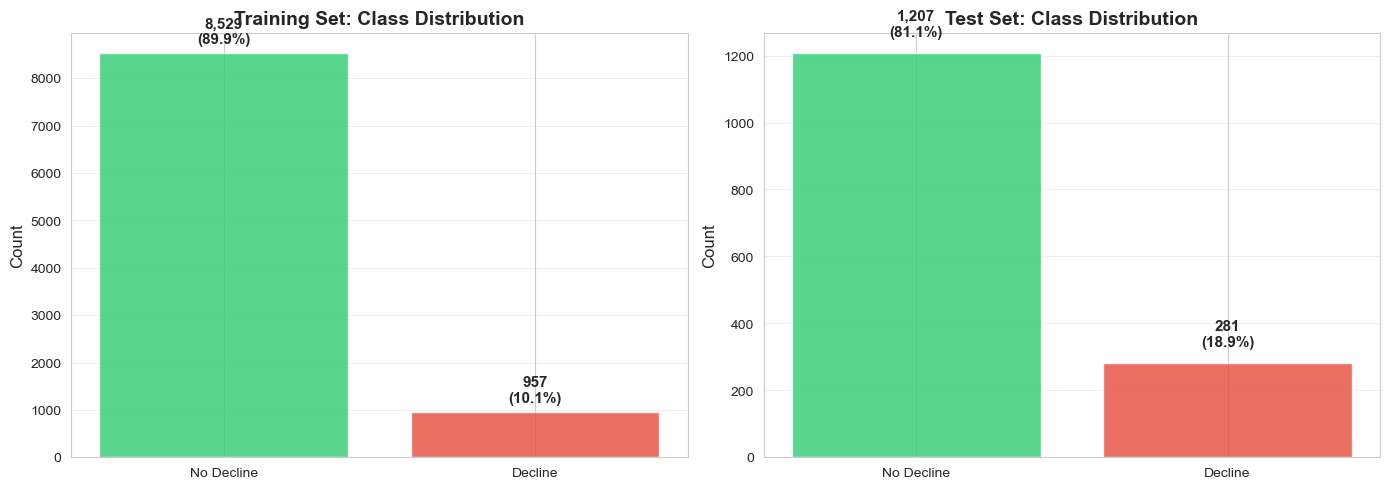

📊 Class balance indicates IMBALANCED dataset - we may need to address this in modeling!


In [35]:
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# 1. Class Balance Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = train_data['future_decline'].value_counts().sort_index()
axes[0].bar(['No Decline', 'Decline'], train_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_title('Training Set: Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].text(0, train_counts[0] + 200, f'{train_counts[0]:,}\n({train_counts[0]/len(train_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[0].text(1, train_counts[1] + 200, f'{train_counts[1]:,}\n({train_counts[1]/len(train_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Test set distribution
test_counts = test_data['future_decline'].value_counts().sort_index()
axes[1].bar(['No Decline', 'Decline'], test_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1].set_title('Test Set: Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].text(0, test_counts[0] + 50, f'{test_counts[0]:,}\n({test_counts[0]/len(test_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[1].text(1, test_counts[1] + 50, f'{test_counts[1]:,}\n({test_counts[1]/len(test_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Class balance indicates", end=" ")
if train_counts[1]/len(train_data) < 0.3:
    print("IMBALANCED dataset - we may need to address this in modeling!")
else:
    print("relatively balanced dataset.")